In [54]:
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
from numpy import concatenate
from pandas import DataFrame
from pandas import concat

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

print(tf.__version__)
model = load_model('modeloFinal.h5', compile = False)

2.4.0


In [55]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Convierte un conjunto de series de tiempo en un conjunto de aprendizaje supervisado

    Params:
        data: secuencia de observaciones
        n_in: tamaño de la ventana, es decir, 2 implica que el siguiente valor
            se calculara con los dos anteriores
        n_out: número de variables a predecir
        dropnan: indica si se eliminarán los valores nulos
    Returns:
    Conjunto de datos de un problema de aprendizaje supervisado
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        # shift
        # se utiliza para desplazar el índice de DataFrame por un número 
        # determinado de períodos con una frecuencia de tiempo opcional
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [56]:
def get_data(df, ventana):
    '''
    Transforma nuestros datos en un formato aceptable para la red separandolos en train y test

    Params:
      df: conjunto de datos 
      ventana: número de días con el que se predecirá el siguiente
    '''
    n_cols = df.shape[1] - 1 # Numero de variables incluyendo la variable objetivo
    entrenamiento = 800 #Cuantos dias de entrenamiento (restante sera para el conjunto test)
    n_obs = ventana*n_cols
    
    
    values = df.iloc[1082:,1:].values# Desde el primer dia del 2018
    transformer = StandardScaler()
    transformer.fit(values)
    # se escalan los datos para que la red trabaje mejor
    transformer_y = StandardScaler()
    transformer_y.fit(df.iloc[1082:,-1].values.reshape(-1,1))

    values = transformer.transform(values)
    # obtenemos un datos para un problema supervisado
    data = series_to_supervised(values, ventana,1 )
    
    train = data.iloc[:entrenamiento,:]
    test = data.iloc[entrenamiento:,:]

    train_X, train_y = train.iloc[:, :n_obs].values, train.iloc[:, -1].values
    test_X, test_y = test.iloc[:, :n_obs].values, test.iloc[:, -1].values
    
    # modificamos las dimensiones del train y test para que tengan un formato
    # (muestras, ventana, numero de variables)
    train_X = train_X.reshape((train_X.shape[0], ventana, n_cols))
    test_X = test_X.reshape((test_X.shape[0], ventana, n_cols))
    return train_X, train_y, test_X, test_y,transformer,transformer_y

In [77]:
def get_ultimo_dia(df, ventana,transformer,transformer_y):
    '''
    Transforma nuestros datos en un formato aceptable para la red separandolos en train y test

    Params:
      df: conjunto de datos 
      ventana: número de días con el que se predecirá el siguiente
    '''
    n_cols = df.shape[1] - 1 # Numero de variables incluyendo la variable objetivo
        
    values = df.iloc[-ventana:,1:].values# Ultima ventana del dataset
    # se escalan los datos para que la red trabaje mejor
    values = transformer.transform(values)
    
    data= values.reshape(-1,n_cols)# se modifica su dimension para que quede coomo una ventana

    data=data.reshape(1,3,n_cols)# se modifica la dimension para que quede como muestra, ventana, num_variables
    return(data)
    

In [48]:
df = pd.read_csv("data_complete.csv")
df.columns

Index(['date', 'dow(USD)', 'euro_stoxx50(USD)', 'nasdaq(USD)', 'nikkei(USD)',
       'oro(USD)', 'petroleo(USD)', 'shangai_stock_exchange(USD)',
       'sp_500(USD)', 'BCHAIN-TOTBC', 'BCHAIN-AVBLS', 'BCHAIN-MIREV (USD)',
       'BCHAIN-HRATE', 'BCHAIN-NTRBL', 'BCHAIN-NADDU', 'eur_usd', 'cny_usd',
       'gbp_usd', 'BCHAIN-MKPRU (USD)'],
      dtype='object')

In [49]:
df.drop(['shangai_stock_exchange(USD)','petroleo(USD)','euro_stoxx50(USD)','dow(USD)'], axis=1, inplace = True)

In [84]:
df

,date,nasdaq(USD),nikkei(USD),oro(USD),sp_500(USD),BCHAIN-TOTBC,BCHAIN-AVBLS,BCHAIN-MIREV (USD),BCHAIN-HRATE,BCHAIN-NTRBL,BCHAIN-NADDU,eur_usd,cny_usd,gbp_usd,BCHAIN-MKPRU (USD)
0,2015-01-04,50.64,19129.75,1184.1,2067.63,13727150.00,0.413363,7.614220e+05,3.038322e+05,824.000000,212403.0,1.1789,0.16140,1.52360,218.11
1,2015-01-05,48.84,19510.85,1294.2,2087.38,13730725.00,0.382308,7.680090e+05,3.256906e+05,731.000000,219873.0,1.1633,0.16140,1.51850,205.35
2,2015-01-06,52.05,20444.54,1266.1,2108.64,13734300.00,0.366155,6.775014e+05,2.994605e+05,633.000000,254267.0,1.1633,0.16140,1.51850,197.12
3,2015-01-07,48.80,20291.05,1280.4,2067.00,13738025.00,0.330078,7.891797e+05,3.256906e+05,703.000000,223392.0,1.1592,0.16105,1.51770,211.18
4,2015-01-09,50.09,18763.72,1268.5,1970.09,13741900.00,0.343386,8.261971e+05,3.388057e+05,740.000000,197559.0,1.1551,0.16070,1.51690,212.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2188,2021-01-02,130.00,27559.10,1901.6,3733.27,18596756.25,1.282691,4.317135e+07,1.628797e+08,2087.201258,768365.0,1.2216,0.15320,1.36720,40240.72
2189,2021-01-03,130.00,27559.10,1901.6,3733.27,18597631.25,1.337252,3.769767e+07,1.577576e+08,2168.558442,801285.0,1.2212,0.15410,1.36695,38240.09
2190,2021-01-04,130.00,27559.10,1901.6,3733.27,18598512.50,1.324212,3.853470e+07,1.516112e+08,2274.506757,796457.0,1.2208,0.15500,1.36670,35544.94
2191,2021-01-05,130.00,27559.10,1901.6,3733.27,18599606.25,1.264866,3.749372e+07,1.557088e+08,2099.782895,772596.0,1.2157,0.15460,1.36400,34011.82


In [61]:
train_X, train_y, test_X, test_y,transformer ,transformer_y = get_data(df, 3)

In [42]:
y_pred=model.predict(test_X)
y_pred_inv=transformer_y.inverse_transform(y_pred)# Transformamos a la escala real de los datos

Text(0.5, 0, 'Numero de dias')

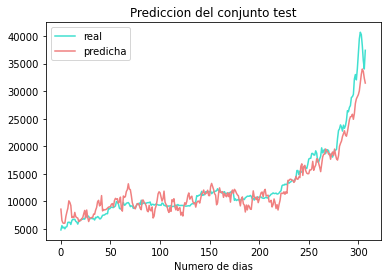

In [43]:
plt.plot(range(0,len(test_X)),df.iloc[-len(test_X):,-1],color="turquoise",label="real")
plt.plot(range(0,len(test_X)),y_pred_inv, color="lightcoral",label="predicha")
plt.legend()
plt.title("Prediccion del conjunto test")
plt.xlabel("Numero de dias")

Text(0.5, 0, 'Numero de dias')

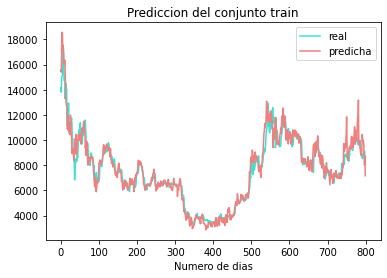

In [44]:
y_pred_t=model.predict(train_X)
y_pred_inv_t=transformer_y.inverse_transform(y_pred_t)# Transformamos a la escala real de los datos
plt.plot(range(0,len(train_X)),df.iloc[1082:1082+len(train_X),-1],color="turquoise",label="real")
plt.plot(range(0,len(train_X)),y_pred_inv_t, color="lightcoral",label="predicha")
plt.legend()
plt.title("Prediccion del conjunto train")
plt.xlabel("Numero de dias")

In [78]:
x_ultimo=get_ultimo_dia(df, 3, transformer, transformer_y)

In [82]:
def predecir(x_ultimo,transformer_y,model):
    y_pred= model.predict(x_ultimo)
    y_pred_inv=transformer_y.inverse_transform(y_pred)
    return y_pred_inv

In [83]:
predecir(x_ultimo,transformer_y,model)

array([[31516.816]], dtype=float32)